In [4]:
# Cell 1: imports & basic constants for the problem
import numpy as np
import matplotlib.pyplot as plt

# === CONSTANTS (tweakable) ===
g = 9.81          # gravity, m/s^2, pulling the comet down
rho0 = 1.225      # air density at sea level, kg/m^3
H = 8500.0        # "scale height" of the atmosphere, m (how fast air thins with altitude)
Cd = 1.3          # drag coefficient (1.3 is a reasonable round number for a blunt-ish object)
rho_b = 1200.0    # bulk density of the comet material, kg/m^3 (ice/rock mix ~ ish)

# Ablation/shaving constant (=larger => faster shrink)
k_default = 1e-3

# === NEW: Ablation model toggle ===
# If True: use a constant wall shear (tau0) for shaving
# If False: use velocity-dependent shear proportional to dynamic pressure
USE_CONST_SHEAR = True
tau0 = 2.0e3      # Pa, constant shear used when USE_CONST_SHEAR is True (tune this)
C_tau = 1.0       # scale factor on 0.5*rho*V^2 when USE_CONST_SHEAR is False


In [5]:
# Cell 2: physics helpers and the ODE right-hand side
# This cell defines the actual "physics" of the comet moving through the air.

def rho_atm(h):
    """
    Compute the air density at altitude h (in meters).

    We assume an exponential atmosphere:
        rho(h) = rho0 * exp(-h / H)
    which just means: 'the higher you go, the thinner the air.'
    """
    return rho0 * np.exp(-h / H)

def rhs(t, y, k_ablate):
    """
    This function tells us: 'given the current state of the comet, how is it changing right now?'

    Inputs:
      t        - current time (seconds). We don't actually use it here, but ODE solvers like to have it.
      y        - current state array: [x, h, vx, vz, R]
                 x  = horizontal position (m)
                 h  = altitude (m, 0 = ground)
                 vx = horizontal velocity (m/s)
                 vz = vertical velocity (m/s), BUT we define positive DOWNWARD
                 R  = radius of the comet (m)
      k_ablate - how fast the comet "shaves" / loses radius due to heating

    Output:
      dydt     - array of time-derivatives, i.e. [dx/dt, dh/dt, dvx/dt, dvz/dt, dR/dt]
      D        - current drag force (N)
      m        - current mass of the comet (kg)
      V        - current speed (m/s)
    """
    x, h, vx, vz, R = y

    # If we dipped below the ground, clamp h to 0 so density doesn't blow up.
    if h < 0:
        h = 0

    # Air density at this altitude
    rho = rho_atm(h)

    # Cross-sectional area of a sphere (what the air "sees")
    A = np.pi * R**2

    # Mass of a solid sphere with density rho_b
    m = (4.0/3.0) * np.pi * R**3 * rho_b

    # Speed magnitude
    V = np.hypot(vx, vz) + 1e-12  # tiny epsilon to avoid divide-by-zero when very slow

    # Drag force magnitude (the usual 1/2 * rho * Cd * A * V^2)
    D = 0.5 * rho * Cd * A * V**2

    # Drag direction is OPPOSITE the velocity.
    # So we take the velocity components and push back on them.
    # Horizontal acceleration from drag:
    ax = -D * (vx / V) / m
    # Vertical acceleration = gravity (down) minus drag (up, because vz is down)
    az = g - D * (vz / V) / m

    # Position time-derivatives:
    dxdt = vx         # horizontal position changes by horizontal velocity
    dhdt = -vz        # altitude goes DOWN when vertical velocity is positive (downward)

    # === NEW: Radius change (shaving) model ===
    # Option A (default here): constant wall shear, tau = tau0
    # Option B: velocity-dependent, tau ~ dynamic pressure
    if USE_CONST_SHEAR:
        tau = tau0
    else:
        tau = C_tau * 0.5 * rho * V**2

    dRdt = -k_ablate * tau

    return np.array([dxdt, dhdt, ax, az, dRdt]), D, m, V


In [6]:
# Cell 3: RK4 simulator (the "engine" that moves time forward)
# RK4 = Runge-Kutta 4th order. It's a standard, stable, accurate way to step ODEs.

def simulate_entry(
    h0=40000.0,        # starting altitude, m (80 km)
    V0=7000.0,         # starting speed, m/s
    gamma_deg=30.0,    # entry angle from horizontal, degrees
    R0=5.0,            # starting radius, m
    k_ablate=0.0,      # 0 = no shaving, >0 = shaving
    dt=0.01,           # time step, s (smaller = more accurate, slower)
    tf=60.0            # max time to simulate, s
):
    """
    Simulate the comet from t=0 to t=tf or until it hits the ground or burns up.

    Returns a dictionary of time histories we can plot or analyze.
    """
    # Convert angle to radians for math
    gamma = np.deg2rad(gamma_deg)

    # Break starting speed into horizontal and vertical parts
    # cos = horizontal, sin = vertical (downward, by our sign convention)
    vx0 = V0 * np.cos(gamma)
    vz0 = V0 * np.sin(gamma)

    # Our initial state vector
    # x starts at 0 (we can assume we are "over" the x-origin)
    y = np.array([0.0, h0, vx0, vz0, R0], dtype=float)
    t = 0.0

    # We'll store everything to look at it later
    ts = [t]
    xs = [y[0]]
    hs = [y[1]]
    vxs = [y[2]]
    vzs = [y[3]]
    Rs = [y[4]]
    Drags = []     # we store drag starting from the FIRST step
    acc_drag = []  # drag-based acceleration (drag / mass)

    # We'll do a fixed number of steps, but we may break early
    N = int(tf / dt)
    for _ in range(N):
        # If we already hit the ground (h <= 0) or burned up (R <= 0), stop.
        if y[1] <= 0 or y[4] <= 0:
            break

        # === RK4 steps ===
        k1, D1, m1, V1 = rhs(t, y, k_ablate)
        k2, _,  _,  _  = rhs(t + dt/2, y + dt*k1/2, k_ablate)
        k3, _,  _,  _  = rhs(t + dt/2, y + dt*k2/2, k_ablate)
        k4, _,  _,  _  = rhs(t + dt,   y + dt*k3,   k_ablate)

        # Combine the 4 slopes to update the state
        y = y + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)
        t = t + dt

        # Save to lists
        ts.append(t)
        xs.append(y[0])
        hs.append(y[1])
        vxs.append(y[2])
        vzs.append(y[3])
        Rs.append(y[4])
        Drags.append(D1)
        acc_drag.append(D1 / m1)

    # if it ended because it burned or hit ground, record that final point too
    if y[1] <= 0 or y[4] <= 0:
        ts.append(t)
        xs.append(y[0])
        hs.append(max(y[1], 0.0))
        vxs.append(y[2])
        vzs.append(y[3])
        Rs.append(max(y[4], 0.0))


    # Convert to numpy arrays so plotting is easy
    return {
        "t": np.array(ts),
        "x": np.array(xs),
        "h": np.array(hs),
        "vx": np.array(vxs),
        "vz": np.array(vzs),
        "R": np.array(Rs),
        "drag": np.array(Drags),
        "a_drag": np.array(acc_drag),
    }


In [7]:
# Cell 4: PHASE 1 – fixed size, change angle & size, NO shaving
# Here we test: if we keep radius constant, how do angle and size change the drag?

angles = [5, 15, 30, 60]          # very shallow to very steep entries
sizes = [0.5, 1.0, 2.0, 5.0]      # small rock to chunky boy

# We'll store results in a dictionary so we can look them up by (size, angle)
results_phase1 = {}

for R0 in sizes:
    for ang in angles:
        # k_ablate = 0 means 'no shaving'
        res = simulate_entry(gamma_deg=ang, R0=R0, k_ablate=0.0)
        key = (R0, ang)

        # Not every run will produce drag points (if it ended super fast)
        max_drag = res["drag"].max() if res["drag"].size > 0 else 0.0

        # How long did the sim run?
        t_final = res["t"][-1]

        # Did we actually touch the ground at some point?
        hit_ground = res["h"][-1] <= 0

        results_phase1[key] = {
            "max_drag": max_drag,
            "t_final": t_final,
            "hit_ground": hit_ground,
        }

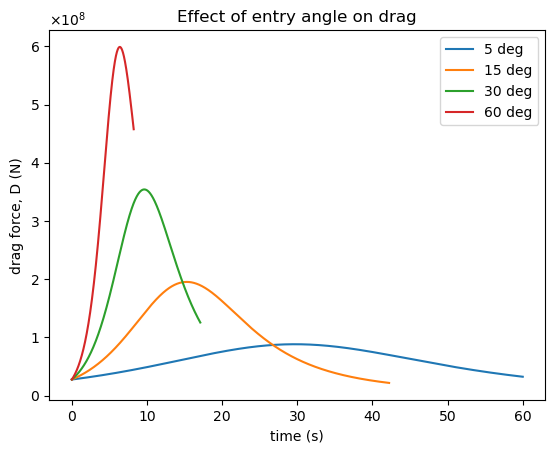

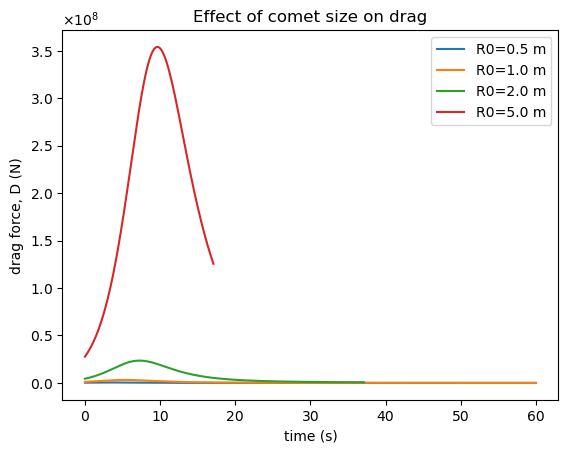

In [8]:
# Cell 5 (linear version): plots for PHASE 1 with big forces shown clearly
import matplotlib.ticker as mtick

plt.figure()
for ang in angles:
    # use bigger R0 so forces aren't tiny
    res = simulate_entry(gamma_deg=ang, R0=5.0, k_ablate=0.0)
    t_drag = res["t"][:len(res["drag"])]
    plt.plot(t_drag, res["drag"], label=f"{ang} deg")
plt.xlabel("time (s)")
plt.ylabel("drag force, D (N)")
plt.title("Effect of entry angle on drag")
plt.legend()

ax = plt.gca()
# show e.g. 1e6, 5e6, ... instead of huge plain numbers
ax.yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.show()

plt.figure()
for R0 in sizes:
    res = simulate_entry(gamma_deg=30.0, R0=R0, k_ablate=0.0)
    t_drag = res["t"][:len(res["drag"])]
    plt.plot(t_drag, res["drag"], label=f"R0={R0} m")
plt.xlabel("time (s)")
plt.ylabel("drag force, D (N)")
plt.title("Effect of comet size on drag")
plt.legend()

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.show()


In [9]:
# Cell 6: PHASE 2 – turn shaving ON and compare to OFF
# This is the "with ablation" version of the same experiments.

k_on = 1e-3   # you can try 5e-6 to make shaving more dramatic

results_phase2 = {}

for R0 in sizes:
    for ang in angles:
        # run once WITHOUT shaving
        res_noshave = simulate_entry(gamma_deg=ang, R0=R0, k_ablate=0.0)
        # run once WITH shaving
        res_shave   = simulate_entry(gamma_deg=ang, R0=R0, k_ablate=k_on)
        key = (R0, ang)

        results_phase2[key] = {
            "max_drag_noshave": res_noshave["drag"].max() if res_noshave["drag"].size else 0,
            "max_drag_shave":   res_shave["drag"].max()   if res_shave["drag"].size else 0,
            "R_final_noshave":  res_noshave["R"][-1],
            "R_final_shave":    res_shave["R"][-1],
            "hit_ground_noshave": res_noshave["h"][-1] <= 0,
            "hit_ground_shave":   res_shave["h"][-1] <= 0,
        }


In [10]:
def _first_event_indices(h, R):
    hit_idx  = np.where(np.asarray(h) <= 0)[0]
    burn_idx = np.where(np.asarray(R) <= 0)[0]
    i_hit  = int(hit_idx[0])  if hit_idx.size  else None
    i_burn = int(burn_idx[0]) if burn_idx.size else None
    return i_hit, i_burn

def _interp_event_time(t, y, i):
    if i == 0: return t[0]
    t0, t1 = t[i-1], t[i]
    y0, y1 = y[i-1], y[i]
    return t0 + (0.0 - y0) * (t1 - t0) / (y1 - y0)

def _clip_series_to_time(t, y, te):
    t = np.asarray(t); y = np.asarray(y)
    j = np.searchsorted(t, te, side="right") - 1
    j = np.clip(j, 0, len(t)-2)
    t0, t1 = t[j], t[j+1]
    y0, y1 = y[j], y[j+1]
    alpha = 0 if t1 == t0 else (te - t0) / (t1 - t0)
    ye = y0 + alpha * (y1 - y0)
    return np.concatenate([t[:j+1], [te]]), np.concatenate([y[:j+1], [ye]])

def classify_and_clip(res):
    """
    Decide outcome by the *first* event (h->0 'hit' or R->0 'burned').
    Returns (status, res_clipped) where time series end exactly at that event.
    If no event occurs, returns ('incomplete', original res).
    """
    t = np.asarray(res["t"]); h = np.asarray(res["h"]); R = np.asarray(res["R"])
    i_hit, i_burn = _first_event_indices(h, R)
    if i_hit is None and i_burn is None:
        return "incomplete", res

    if i_hit is not None and (i_burn is None or i_hit < i_burn):
        status = "hit"; te = _interp_event_time(t, h, i_hit)
    else:
        status = "burned"; te = _interp_event_time(t, R, i_burn)

    clipped = {}
    # clip time-aligned arrays
    for k, v in res.items():
        v_arr = np.asarray(v) if isinstance(v, (list, np.ndarray)) else v
        if isinstance(v_arr, np.ndarray):
            if len(v_arr) == len(t):           # same length as t -> clip to te
                _, y_clip = _clip_series_to_time(t, v_arr, te)
                clipped[k] = y_clip
            elif len(v_arr) == len(t) - 1:     # one shorter (e.g., per-step arrays like 'drag')
                # align with t[:-1]
                t_short = t[:-1]
                _, y_clip = _clip_series_to_time(t_short, v_arr, te)
                clipped[k] = y_clip
            else:
                clipped[k] = v_arr
        else:
            clipped[k] = v
    # set clipped time explicitly
    t_clip, _ = _clip_series_to_time(t, t, te)
    clipped["t"] = t_clip
    return status, clipped

def time_for_steps(res, key="drag"):
    """Return (t_match, y) where len(t_match) == len(res[key])."""
    t = np.asarray(res["t"])
    y = np.asarray(res[key])
    n = min(len(t), len(y))
    return t[:n], y[:n]

# === Critical-radius finder (bisection over R0) ===
# Assumes: simulate_entry(gamma_deg=..., R0=..., k_ablate=...) exists
#          classify_and_clip(res) -> ("hit"|"burned"|"incomplete", res_clipped)

def _outcome(gamma_deg, R0, k_ablate):
    """Return +1 if hit ground, -1 if burned up, 0 if incomplete (no event before tf)."""
    res = simulate_entry(gamma_deg=gamma_deg, R0=R0, k_ablate=k_ablate)
    status, _ = classify_and_clip(res)
    if status == "hit":      return +1
    if status == "burned":   return -1
    return 0  # incomplete

def find_critical_radius(gamma_deg, k_ablate,
                         R_low=0.1, R_high=200.0,
                         tol=5e-2, max_iter=40, verbose=False):
    """
    Find Rcrit where behavior flips from 'burned' to 'hit'.
    Monotonicity: for this model, larger R is more likely to HIT.
       outcome(R) ~ -1 (burned)  --> +1 (hit) as R increases.

    Args
    ----
    gamma_deg : float
    k_ablate  : float
    R_low, R_high : bracket radii (R_low must burn, R_high must hit)
    tol       : stop when (R_high - R_low) <= tol
    max_iter  : bisection iterations
    verbose   : print progress

    Returns
    -------
    Rcrit : float or None if a valid bracket couldn't be established.
    """

    s_low  = _outcome(gamma_deg, R_low,  k_ablate)
    s_high = _outcome(gamma_deg, R_high, k_ablate)

    # Try to coerce any 'incomplete' to a definite outcome by nudging the radius
    def _coerce(side_R, side_s, sign):
        # sign = -1 for low side (favor burning), +1 for high side (favor hitting)
        if side_s != 0:
            return side_R, side_s
        # slight nudge to try to trigger an event without changing bracket much
        for f in (1.01, 1.02, 0.98, 0.97):
            R_try = side_R * (f if sign > 0 else (2 - f))
            s_try = _outcome(gamma_deg, R_try, k_ablate)
            if s_try != 0:
                return R_try, s_try
        return side_R, side_s

    R_low,  s_low  = _coerce(R_low,  s_low,  -1)
    R_high, s_high = _coerce(R_high, s_high, +1)

    if verbose:
        print(f"bracket: R_low={R_low:.3g} (s={s_low}), R_high={R_high:.3g} (s={s_high})")

    # Validate bracket: low must burn (-1), high must hit (+1)
    if s_low != -1 or s_high != +1:
        if verbose:
            print("Could not establish a valid bracket. "
                  "Increase R_high if both burn, or decrease R_low if both hit.")
        return None

    a, b = R_low, R_high
    for it in range(max_iter):
        m = 0.5 * (a + b)
        s = _outcome(gamma_deg, m, k_ablate)
        if verbose:
            print(f"it {it:02d}: R_mid={m:.6g}, outcome={s}")
        if s == 0:
            # incomplete at mid: nudge slightly toward the side that should resolve it
            # try a tiny push toward 'hit' first (larger R), then toward 'burn'
            for scale in (1.005, 0.995, 1.01, 0.99):
                s_try = _outcome(gamma_deg, m*scale, k_ablate)
                if s_try != 0:
                    s = s_try
                    m = m*scale
                    break
            # if still incomplete, treat as burned (conservative; pushes search upward)
            if s == 0:
                s = -1

        if s < 0:   # burned -> move lower bound up
            a = m
        else:       # hit -> move upper bound down
            b = m

        if (b - a) <= tol:
            return 0.5 * (a + b)

    # if we exit loop without converging, return midpoint
    return 0.5 * (a + b)




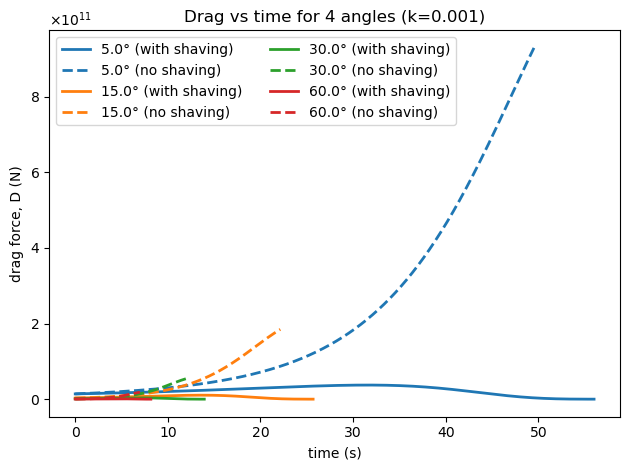

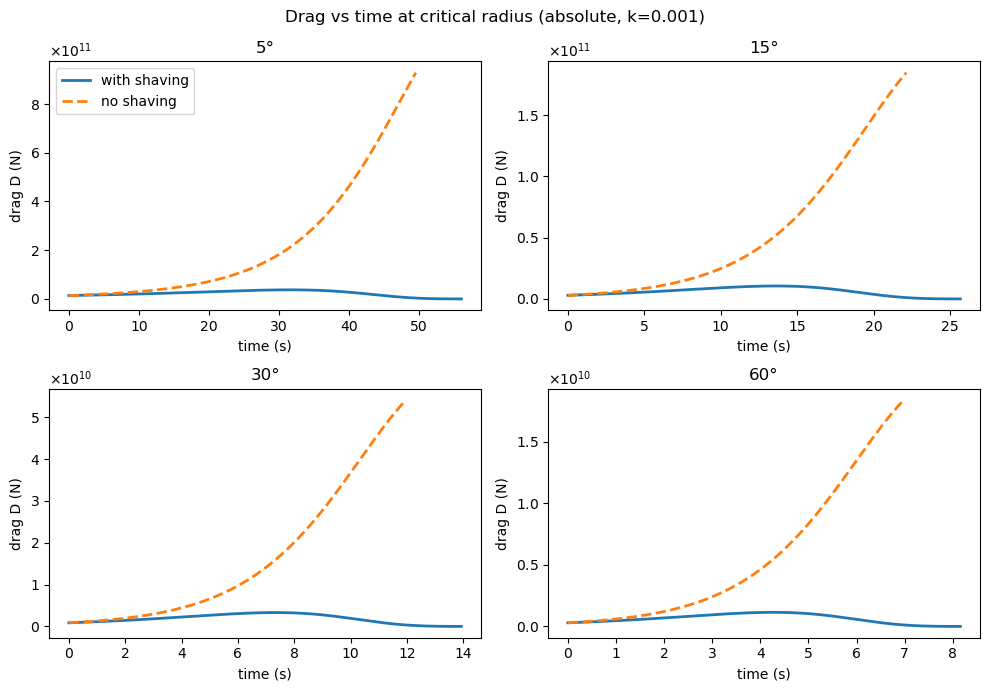

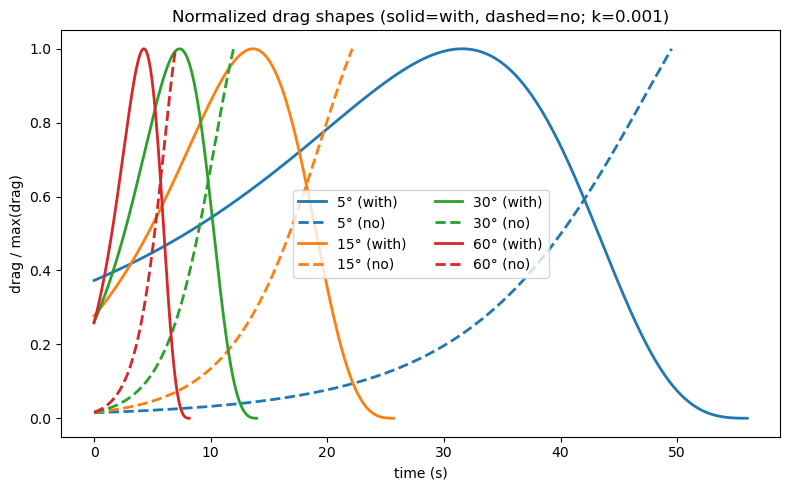

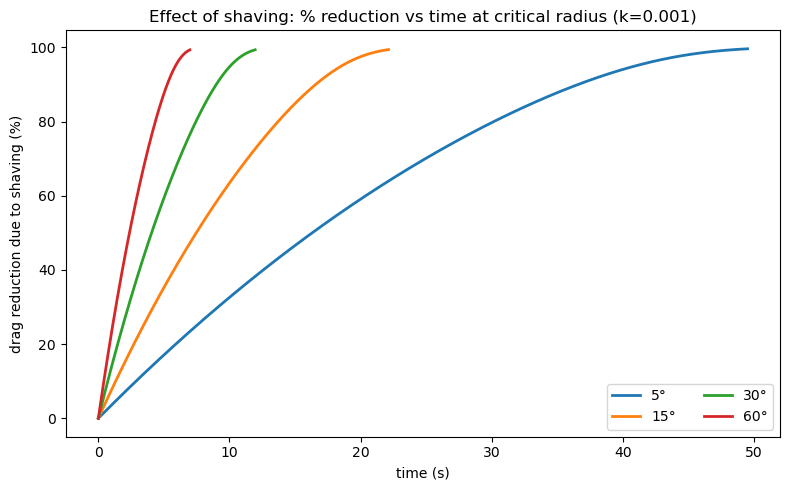

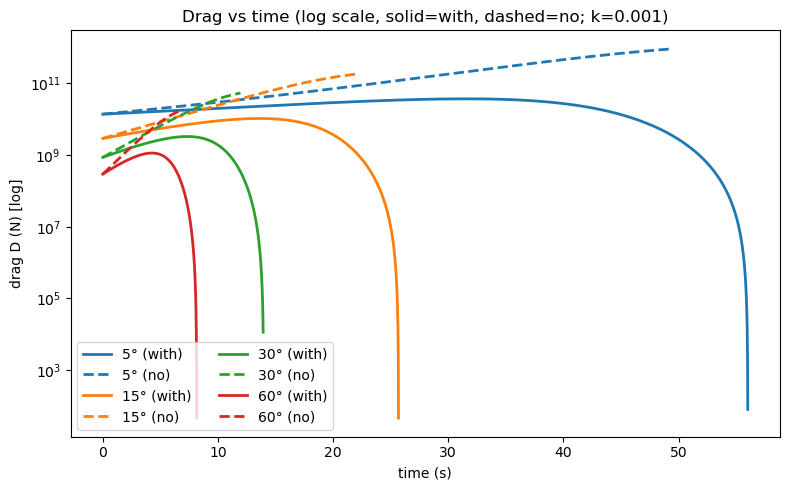

In [11]:
# Drag vs time: with shaving (solid) vs no shaving (dashed), per angle
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

angles_to_test = [5.0, 15.0, 30.0, 60.0]
k_used = 1e-3

plt.figure()
for ang in angles_to_test:
    Rcrit = find_critical_radius(gamma_deg=ang, k_ablate=k_used,
                                 R_low=0.1, R_high=200.0, tol=5e-2, max_iter=40)

    res_with = simulate_entry(gamma_deg=ang, R0=Rcrit, k_ablate=k_used)
    _, res_with = classify_and_clip(res_with)
    t_w, d_w = time_for_steps(res_with, "drag")

    res_noshave = simulate_entry(gamma_deg=ang, R0=Rcrit, k_ablate=0.0)
    _, res_noshave = classify_and_clip(res_noshave)
    t_n, d_n = time_for_steps(res_noshave, "drag")

    line_with, = plt.plot(t_w, d_w, lw=2, label=f"{ang:.1f}° (with shaving)")
    plt.plot(t_n, d_n, lw=2, ls="--", color=line_with.get_color(),
             label=f"{ang:.1f}° (no shaving)")

plt.xlabel("time (s)")
plt.ylabel("drag force, D (N)")
plt.title(f"Drag vs time for 4 angles (k={k_used})")
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

angles_to_test = [5.0, 15.0, 30.0, 60.0]
k_used = 1e-3

# --- run once per angle: get with/without shaving, clipped to first event
runs = {}
for ang in angles_to_test:
    Rcrit = find_critical_radius(gamma_deg=ang, k_ablate=k_used,
                                 R_low=0.1, R_high=200.0, tol=5e-2, max_iter=40)
    res_w = simulate_entry(gamma_deg=ang, R0=Rcrit, k_ablate=k_used)
    _, res_w = classify_and_clip(res_w)
    res_n = simulate_entry(gamma_deg=ang, R0=Rcrit, k_ablate=0.0)
    _, res_n = classify_and_clip(res_n)
    # pick time vectors that match per-step arrays
    t_w  = res_w.get("t_step", res_w["t"][:len(res_w["drag"])])
    t_n  = res_n.get("t_step", res_n["t"][:len(res_n["drag"])])
    D_w  = np.asarray(res_w["drag"])
    D_n  = np.asarray(res_n["drag"])
    runs[ang] = (t_w, D_w, t_n, D_n)

# ---------- View 2: Small multiples (2×2), absolute drag per angle ----------
fig, axs = plt.subplots(2, 2, figsize=(10, 7), sharex=False)
axs = axs.ravel()
for ax, ang in zip(axs, angles_to_test):
    t_w, D_w, t_n, D_n = runs[ang]
    lw = 2
    ax.plot(t_w, D_w, lw=lw, label="with shaving")
    ax.plot(t_n, D_n, lw=lw, ls="--", label="no shaving")
    ax.set_title(f"{ang:.0f}°")
    ax.set_xlabel("time (s)")
    ax.set_ylabel("drag D (N)")
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
axs[0].legend(loc="best")
fig.suptitle(f"Drag vs time at critical radius (absolute, k={k_used})", y=0.98)
fig.tight_layout()
plt.show()

# ---------- View 3: Normalized drag (shape-only), both curves in [0,1] ----------
plt.figure(figsize=(8, 5))
for ang in angles_to_test:
    t_w, D_w, t_n, D_n = runs[ang]
    # normalize by each curve's own max to compare shapes
    if D_w.max() > 0:
        line, = plt.plot(t_w, D_w / D_w.max(), lw=2, label=f"{ang:.0f}° (with)")
        plt.plot(t_n, D_n / D_n.max(), lw=2, ls="--", color=line.get_color(),
                 label=f"{ang:.0f}° (no)")
plt.xlabel("time (s)")
plt.ylabel("drag / max(drag)")
plt.title(f"Normalized drag shapes (solid=with, dashed=no; k={k_used})")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

# ---------- View 4: Percent reduction due to shaving (single curve per angle) ----------
def interp_to_common(t_ref, t_src, y_src):
    # safe 1D interpolation onto t_ref; extrapolate with edge values
    return np.interp(t_ref, t_src, y_src, left=y_src[0], right=y_src[-1])

plt.figure(figsize=(8, 5))
for ang in angles_to_test:
    t_w, D_w, t_n, D_n = runs[ang]
    # compare only over the overlapping time window
    t_end = min(t_w[-1], t_n[-1])
    # build a common time grid (use the denser of the two)
    dt = min(np.diff(t_w).mean() if len(t_w)>1 else t_end,
             np.diff(t_n).mean() if len(t_n)>1 else t_end)
    if not np.isfinite(dt) or dt <= 0: dt = t_end/200 if t_end>0 else 1.0
    t_common = np.arange(0.0, t_end, dt)
    Dw = interp_to_common(t_common, t_w, D_w)
    Dn = interp_to_common(t_common, t_n, D_n)
    # avoid divide-by-zero
    mask = Dn > 0
    pct = np.zeros_like(Dn)
    pct[mask] = 100.0 * (1.0 - Dw[mask]/Dn[mask])
    line, = plt.plot(t_common, pct, lw=2, label=f"{ang:.0f}°")
plt.xlabel("time (s)")
plt.ylabel("drag reduction due to shaving (%)")
plt.title(f"Effect of shaving: % reduction vs time at critical radius (k={k_used})")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

# ---------- View 5: log-scale absolute overlay (compress the giant outlier) ----------
plt.figure(figsize=(8, 5))
for ang in angles_to_test:
    t_w, D_w, t_n, D_n = runs[ang]
    line, = plt.plot(t_w, D_w, lw=2, label=f"{ang:.0f}° (with)")
    plt.plot(t_n, D_n, lw=2, ls="--", color=line.get_color(), label=f"{ang:.0f}° (no)")
plt.yscale('log')
plt.xlabel("time (s)")
plt.ylabel("drag D (N) [log]")
plt.title(f"Drag vs time (log scale, solid=with, dashed=no; k={k_used})")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()



=== angle = 5.0 deg ===
  critical R ≈ 112.03 m


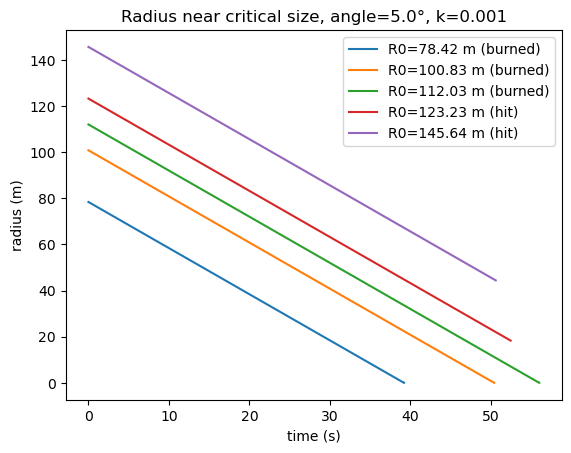


=== angle = 15.0 deg ===
  critical R ≈ 51.37 m


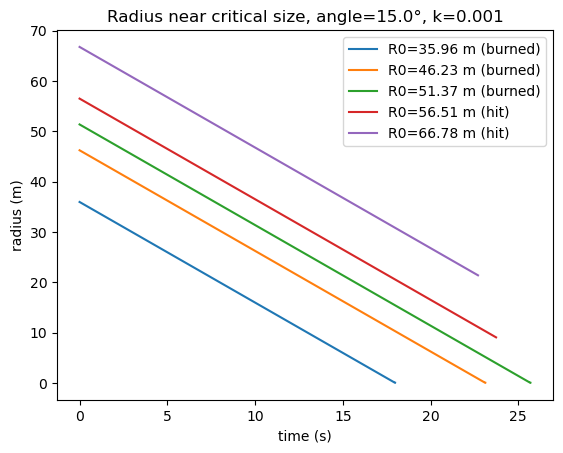


=== angle = 30.0 deg ===
  critical R ≈ 27.94 m


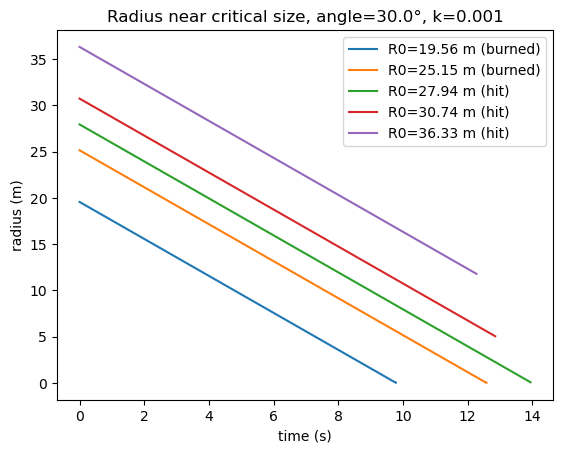


=== angle = 60.0 deg ===
  critical R ≈ 16.33 m


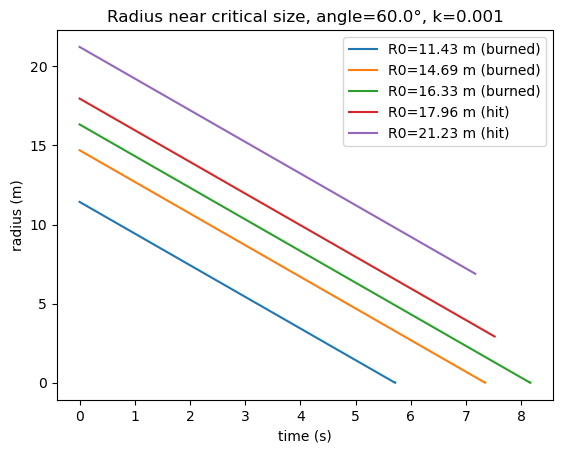

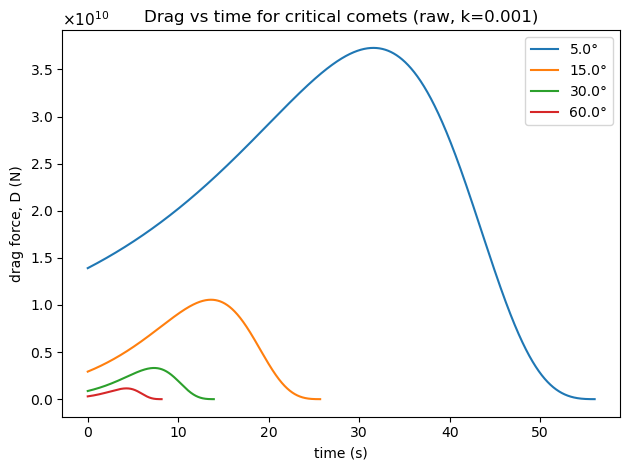

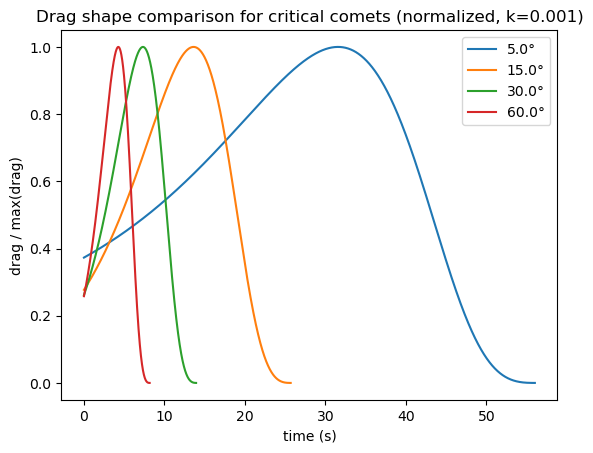

In [12]:
# Final cell: multi-angle + drag for critical comets

angles_to_test = [5.0, 15.0, 30.0, 60.0]
k_used = 1e-3
R_high_default = 200.0

# we'll stash critical drag curves here
crit_drags = []   # list of (angle, t, drag)

for ang in angles_to_test:
    print(f"\n=== angle = {ang} deg ===")
    Rcrit = find_critical_radius(
        gamma_deg=ang,
        k_ablate=k_used,
        R_low=0.1,
        R_high=R_high_default,
        tol=5e-2,
        max_iter=40
    )
    if Rcrit is None:
        print("No critical radius found in the search bracket; try larger R_high.")
        continue
    print(f"  critical R ≈ {Rcrit:.2f} m")

    # 1) radius-near-critical plot
    radii_test = [0.7*Rcrit, 0.9*Rcrit, Rcrit, 1.1*Rcrit, 1.3*Rcrit]
    plt.figure()
    for R0 in radii_test:
        res = simulate_entry(gamma_deg=ang, R0=R0, k_ablate=k_used)
        # Improved status: hit vs burned vs incomplete (ran out of tf)
        hit  = res["h"][-1] <= 0
        burn = res["R"][-1] <= 0
        status = 'hit' if hit else ('burned' if burn else 'incomplete')
        label = f"R0={R0:.2f} m ({status})"
        plt.plot(res["t"], res["R"], label=label)
    plt.xlabel("time (s)")
    plt.ylabel("radius (m)")
    plt.title(f"Radius near critical size, angle={ang}°, k={k_used}")
    plt.legend()
    plt.show()

    # 2) store the exact-critical run for the final drag plot
    res_crit = simulate_entry(gamma_deg=ang, R0=Rcrit, k_ablate=k_used)
    t_drag = res_crit["t"][:len(res_crit["drag"])]
    crit_drags.append((ang, t_drag, res_crit["drag"]))

# 5th graph: drag vs time for all critical comets
if crit_drags:
    import matplotlib.ticker as mtick

    # 5a) raw drag with scientific-notation axis (offset text ×10^N)
    import matplotlib.ticker as mtick
    from matplotlib.ticker import ScalarFormatter

    plt.figure()
    for ang, t_drag, drag in crit_drags:
        plt.plot(t_drag, drag, label=f"{ang}°")

    plt.xlabel("time (s)")
    plt.ylabel("drag force, D (N)")
    plt.title(f"Drag vs time for critical comets (raw, k={k_used})")

    ax = plt.gca()
    sf = ScalarFormatter(useMathText=True)
    sf.set_scientific(True)
    sf.set_powerlimits((0, 0))        # always use scientific notation
    ax.yaxis.set_major_formatter(sf)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(11)   # the little ×10^N text

    plt.legend()
    plt.tight_layout()
    plt.show()


    # 5b) normalized drag so the small ones don't look like 0
    plt.figure()
    for ang, t_drag, drag in crit_drags:
        if drag.max() > 0:
            plt.plot(t_drag, drag / drag.max(), label=f"{ang}°")
    plt.xlabel("time (s)")
    plt.ylabel("drag / max(drag)")
    plt.title(f"Drag shape comparison for critical comets (normalized, k={k_used})")
    plt.legend()
    plt.show()
else:
    print("No angles produced a surviving (critical) comet. Try smaller k or bigger R_high.")




In [13]:
# QoIs for one run at a given dt
def run_qoi(gamma_deg, R0, k_ablate, dt):
    res = simulate_entry(gamma_deg=gamma_deg, R0=R0, k_ablate=k_ablate, dt=dt)
    status, res = classify_and_clip(res)
    t_end = float(res["t"][-1])
    D = np.asarray(res["drag"])
    Dmax = float(D.max()) if D.size else 0.0
    x_end = float(res["x"][-1]) if "x" in res else np.nan
    return {"status": status, "t_event": t_end, "Dmax": Dmax, "x_event": x_end}

# pick one representative case for the error study
GAMMA_TEST = 30.0      # degrees
R0_TEST    = 30.0      # meters (any that 'hits' is fine; keep it consistent)
K_USED     = 1e-3      # your shaving constant

# time steps to test (geometric sequence)
dts = np.array([0.4, 0.2, 0.1, 0.05, 0.025, 0.0125])  # adjust if your integrator expects smaller/larger
dt_ref = dts[-1] / 8.0                                 # much smaller "reference" step

# reference solution
q_ref = run_qoi(GAMMA_TEST, R0_TEST, K_USED, dt_ref)


Estimated order (t_event): 2.05
Estimated order (Dmax)  : 2.06
Estimated order (x_event): 2.05


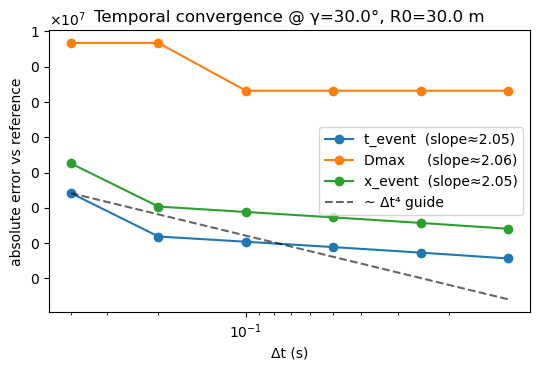

In [14]:
# Run all dts and compute absolute errors against the reference
errs_t, errs_D, errs_x = [], [], []
for dt in dts:
    q = run_qoi(GAMMA_TEST, R0_TEST, K_USED, dt)
    # If an outcome changes (burn vs hit) at coarse dt, skip that dt for fair comparison
    if q["status"] != q_ref["status"]:
        errs_t.append(np.nan); errs_D.append(np.nan); errs_x.append(np.nan)
        continue
    errs_t.append(abs(q["t_event"] - q_ref["t_event"]))
    errs_D.append(abs(q["Dmax"]   - q_ref["Dmax"]))
    errs_x.append(abs(q["x_event"] - q_ref["x_event"]))

errs_t = np.array(errs_t); errs_D = np.array(errs_D); errs_x = np.array(errs_x)

# Fit slopes on log-log (ignore NaNs/zeros)
def slope(x, y):
    m = (~np.isnan(y)) & (y>0)
    return np.polyfit(np.log10(x[m]), np.log10(y[m]), 1)[0] if m.sum()>=2 else np.nan

s_t = slope(dts, errs_t); s_D = slope(dts, errs_D); s_x = slope(dts, errs_x)
print(f"Estimated order (t_event): {s_t:.2f}")
print(f"Estimated order (Dmax)  : {s_D:.2f}")
print(f"Estimated order (x_event): {s_x:.2f}")

# Plots
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

def sci(ax):
    sf = ScalarFormatter(useMathText=True); sf.set_scientific(True); sf.set_powerlimits((0,0))
    ax.yaxis.set_major_formatter(sf); ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.figure(figsize=(5.5,4))
plt.loglog(dts, errs_t, 'o-', label=f"t_event  (slope≈{s_t:.2f})")
plt.loglog(dts, errs_D, 'o-', label=f"Dmax     (slope≈{s_D:.2f})")
plt.loglog(dts, errs_x, 'o-', label=f"x_event  (slope≈{s_x:.2f})")
# reference 4th-order guide line
k = np.nanmax(errs_t)/ (dts[0]**4) if np.isfinite(np.nanmax(errs_t)) else 1.0
plt.loglog(dts, k*dts**4, 'k--', alpha=0.6, label="~ Δt⁴ guide")
plt.gca().invert_xaxis()
plt.xlabel("Δt (s)"); plt.ylabel("absolute error vs reference")
plt.title(f"Temporal convergence @ γ={GAMMA_TEST}°, R0={R0_TEST} m")
plt.legend(); sci(plt.gca()); plt.tight_layout(); plt.show()


Estimated order (fixed time): 3.75


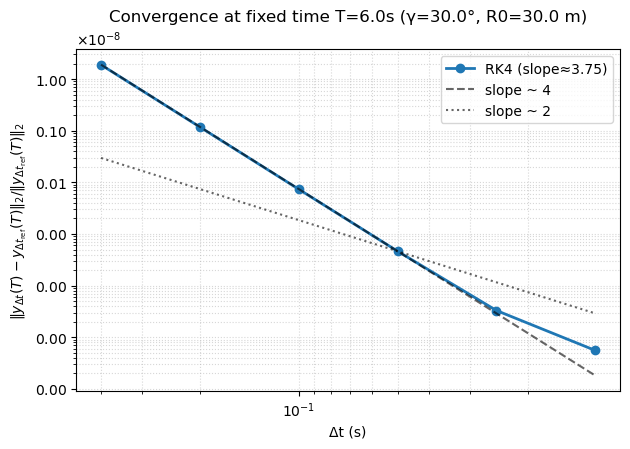

In [15]:
# Fixed-time temporal convergence for RK4 (slope ~ 4 expected)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# ---- choose a representative case & a safe T (before any event) ----
GAMMA_TEST = 30.0     # deg
R0_TEST    = 30.0     # m
K_USED     = 1e-3
T_FINAL    = 6.0      # seconds; ensure no run hits/burns before this

# ---- time steps to test (coarse -> fine) + a tiny reference step ----
dts = np.array([0.4, 0.2, 0.1, 0.05, 0.025, 0.0125])
dt_ref = dts[-1] / 8.0

def sample_at_T(res, T):
    """Return state vector at time T by simple linear interpolation."""
    t = np.asarray(res["t"])
    # pick state components to include in the error norm (exclude drag because it's per-step)
    y_parts = []
    for key in ("x","h","vx","vz","R"):
        y_parts.append(np.asarray(res[key]))
    Y = np.vstack(y_parts)  # shape (5, n)

    # find segment bracketing T
    if T <= t[0]: return Y[:,0]
    if T >= t[-1]: return Y[:,-1]
    j = np.searchsorted(t, T)  # t[j-1] < T <= t[j]
    t0, t1 = t[j-1], t[j]
    a = (T - t0)/(t1 - t0)
    return (1-a)*Y[:,j-1] + a*Y[:,j]

def run_to_T(dt):
    # your simulate_entry should accept dt (or read a global); integrate far enough past T_FINAL
    res = simulate_entry(gamma_deg=GAMMA_TEST, R0=R0_TEST, k_ablate=K_USED, dt=dt, tf=T_FINAL+5.0)
    # IMPORTANT: don't clip to event here; we want the state at T even if an event happens later
    return sample_at_T(res, T_FINAL)

# reference
y_ref = run_to_T(dt_ref)
ref_norm = np.linalg.norm(y_ref, ord=2)

# sweep dts
errs = []
for dt in dts:
    y = run_to_T(dt)
    e = np.linalg.norm(y - y_ref, ord=2)
    errs.append(e / (ref_norm if ref_norm>0 else 1.0))
errs = np.array(errs)

# slope fit on log–log
m, b = np.polyfit(np.log10(dts), np.log10(errs), 1)
print(f"Estimated order (fixed time): {m:.2f}")

# plot like your class example
plt.figure(figsize=(6.4,4.6))
plt.loglog(dts, errs, 'o-', lw=2, label=f"RK4 (slope≈{m:.2f})")

# guide lines with slopes 2 and 4 through the middle point
k4 = errs[len(errs)//2] / (dts[len(errs)//2]**4)
k2 = errs[len(errs)//2] / (dts[len(errs)//2]**2)
plt.loglog(dts, k4*dts**4, 'k--', alpha=0.6, label="slope ~ 4")
plt.loglog(dts, k2*dts**2, 'k:',  alpha=0.6, label="slope ~ 2")

plt.gca().invert_xaxis()
plt.xlabel("Δt (s)")
plt.ylabel(r"$\|y_{\Delta t}(T)-y_{\Delta t_\mathrm{ref}}(T)\|_2 / \|y_{\Delta t_\mathrm{ref}}(T)\|_2$")
plt.title(f"Convergence at fixed time T={T_FINAL}s (γ={GAMMA_TEST}°, R0={R0_TEST} m)")
sf = ScalarFormatter(useMathText=True); sf.set_scientific(True); sf.set_powerlimits((0,0))
plt.gca().yaxis.set_major_formatter(sf); plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.grid(True, which='both', ls=':', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# Choose Δt so QoIs meet tolerances (edit tolerances to what you care about)
REL_TOL_DMAX = 5e-3     # 0.5% on peak drag
ABS_TOL_TEVT = 0.05     # 0.05 s on event time
ABS_TOL_X    = 5.0      # 5 m on range

good = []
for dt, Et, ED, Ex in zip(dts, errs_t, errs_D, errs_x):
    ok = True
    if not np.isnan(ED) and q_ref["Dmax"]>0:
        ok &= (ED / q_ref["Dmax"] <= REL_TOL_DMAX)
    if not np.isnan(Et):
        ok &= (Et <= ABS_TOL_TEVT)
    if not np.isnan(Ex):
        ok &= (Ex <= ABS_TOL_X)
    if ok: good.append(dt)

chosen_dt = min(good) if len(good) else dts[-1]
print(f"Recommended Δt = {chosen_dt} s "
      f"(meets: {REL_TOL_DMAX*100:.2f}% on Dmax, {ABS_TOL_TEVT}s on t_event, {ABS_TOL_X} m on range)")


Recommended Δt = 0.0125 s (meets: 0.50% on Dmax, 0.05s on t_event, 5.0 m on range)


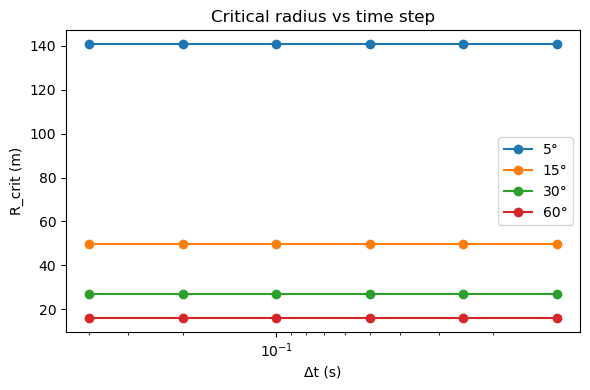

In [17]:
def Rcrit_at_dt(gamma_deg, k_ablate, dt):
    return find_critical_radius(gamma_deg=gamma_deg, k_ablate=k_ablate,
                                R_low=0.1, R_high=200.0, tol=5e-2, max_iter=40, 
                                # pass dt through via simulate_entry's default/global if needed:
                                )

# If find_critical_radius doesn't forward dt, add a dt argument internally or set a global.
# Here we just run with the global inside simulate_entry; skip this block if you already pass dt in.

gammas = [5.0, 15.0, 30.0, 60.0]
Rcrit_dt = {g: [] for g in gammas}
for dt in dts:
    # If your simulate_entry reads a global DT, set it here (optional)
    # DT = dt  # uncomment if you use a module-level dt
    for g in gammas:
        Rc = Rcrit_at_dt(g, K_USED if 'K_USED' in globals() else k_used, dt)
        Rcrit_dt[g].append(Rc)

# Plot Rcrit vs Δt
plt.figure(figsize=(6,4))
for g in gammas:
    plt.semilogx(dts, Rcrit_dt[g], 'o-', label=f"{g:.0f}°")
plt.gca().invert_xaxis()
plt.xlabel("Δt (s)"); plt.ylabel("R_crit (m)")
plt.title("Critical radius vs time step")
plt.legend(); plt.tight_layout(); plt.show()
